# Discontinuation Prediction Pipeline (Longitudinal EHR) — LSTM/XLSTM

End-to-end pipeline to:

1. Load and clean a longitudinal dataset with multiple `VISIT_DT` per `PATIENT_NUM`.
2. Drop NA-heavy columns and NA rows per configurable thresholds.
3. Handle scaling and class balancing.
4. Sort visits in ascending order per patient.
5. Compute `CumulDays` per patient and define `DISCONT_DAY` as `max(CumulDays)`.
6. Prepare sequences and train an LSTM-based model (with an **optional** XLSTM drop-in) to predict:
   - **Binary classification**: whether the patient will discontinue **on/before** a threshold number of days (default: 90 days), **or**
   - **Regression**: predict the actual `DISCONT_DAY`.
7. Evaluate with AUC-ROC, Accuracy, F1 (classification) and MAE/RMSE/R² (regression).
8. Plot diagnostic charts.

> **Notes**
> - This notebook uses PyTorch for the model and scikit-learn/pandas for preprocessing and metrics.
> - If you specifically want the **xLSTM** variant from research libraries, set `USE_XLSTM=True` in the Model section and ensure the corresponding package is installed (see the import cell). The baseline LSTM **just works** without extra packages.
> - All evaluation splits are **patient-level** to prevent leakage.


## 0) Environment & Packages
Run the cell below. If a library is missing locally, uncomment the `pip install` lines and run again.

In [1]:
# from utils import *
# import utils

In [2]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

In [3]:
from utils import base_configs, deps, tr_va_te_split, tr_va_te_shap_run
from utils.helpers import data_helpers, dir_helpers, rw_csv_helpers, data_clean_helpers
from utils.helpers import data_encode_helpers, seq_helpers

In [4]:
current_work_dir = dir_helpers.get_cwd(1)

Current working directory: /home/ppanta/puru_proj/proj_v1/discont_v1


## 1) Configuration
Edit the paths and knobs here to match your environment and preferences.

In [5]:
CONFIG = base_configs.get_base_config(return_type="dict", verbose=1)

Config Info: {'IP_CSV_COHORT_PRE_EPIC': 'ip/data_UKHC_5092/COHORT_PRE_EPIC_DEID.csv', 'OP_CSV_COHORT_PRE_EPIC_CLEANED': 'op/COHORT_PRE_EPIC_DEID_cols_added.csv', 'PATIENT_NUM': 'PATIENT_NUM', 'VISIT_NUM': 'VISIT_NUM', 'VISIT_DT': 'VISIT_DT', 'AGE': 'AGE', 'TASK_CLASSIF': 'classification', 'TASK_REGRESS': 'regression', 'DISCONT_THRESHOLD_DAYS': 11, 'DROP_COL_MISSING_FRAC': 0.6, 'DROP_ROW_MISSING_FRAC': 0.6, 'SCALE_NUMERIC': True, 'SPLIT_SEED': 42, 'TRAIN_FRAC': 0.6, 'VAL_FRAC': 0.2, 'TEST_FRAC': 0.2, 'USE_XLSTM': False, 'MAX_SEQ_LEN': 256, 'HIDDEN_SIZE': 128, 'NUM_LAYERS': 2, 'BIDIRECTIONAL': False, 'DROPOUT': 0.2, 'BATCH_SIZE': 64, 'EPOCHS': 20, 'LR': 0.001, 'WEIGHT_DECAY': 0.0001, 'EARLY_STOP_PATIENCE': 4, 'OUT_DIR': 'op'}


## 2) Load + Quick Standardization
This section loads your CSV, normalizes column names, and ensures core fields exist.

In [6]:
IP_CSV_COHORT_PRE_EPIC = CONFIG['IP_CSV_COHORT_PRE_EPIC']
OP_CSV_COHORT_PRE_EPIC_CLEANED = CONFIG['OP_CSV_COHORT_PRE_EPIC_CLEANED']

df_orig = rw_csv_helpers.read_csv_file(csv_path=OP_CSV_COHORT_PRE_EPIC_CLEANED, verbose=1)

Loaded: /home/ppanta/puru_proj/proj_v1/discont_v1/op/COHORT_PRE_EPIC_DEID_cols_added.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (59091, 30)
────────────────────────────────────────────────────────────────────────────────
All columns: ['COHORT', 'VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE', 'RACE', 'ETHNICITY', 'COUNTY', 'RURAL_URBAN_CODE', 'RURAL_URBAN', 'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET', 'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC', 'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID', 'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX', 'ADMT_FACILITY_CD_DES', 'DIFF_DAYS', 'CUMUL_DAYS_REF_THIS_PATIENT_MIN', 'CUMUL_DAYS_REF_ALL_PATIENT_MIN', 'IS_WITHIN_THRESHOLD_DAY', 'PATIENT_DISCONT_DAYS', 'IS_DISCONT_IN_THRESHOLD', 'THRESHOLD_DAYS', 'THRESHOLD_KIND']


In [7]:
df = df_orig.copy()
# df.sample(3)

## 3) Clean-up: NA handling, types, sorting, CumulDays & Discontinuation
- Converts `VISIT_DT` to datetime.
- Drops columns and rows with too much missingness.
- Sorts visits per patient.
- Builds `CumulDays` per `PATIENT_NUM` and the scalar `DISCONT_DAY`.

In [8]:
df = data_clean_helpers.col_clean(CONFIG = CONFIG, df=df.copy(), verbose=1)

Dropped columns (too-missing): []
Shape (cleaned): (59091, 16)


In [9]:
print(f"# Of columns in df: {len(df.columns)}")
display(df.columns)

# Of columns in df: 16


Index(['VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE',
       'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET',
       'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC',
       'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID',
       'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX',
       'DISCONT_DAY'],
      dtype='object')

### 3a) Label Construction
- **Classification**: `label = 1` if `DISCONT_DAY <= DISCONT_THRESHOLD_DAYS`; else `0`.
- **Regression**: `label = DISCONT_DAY`.

We create a single label per patient and keep all per-visit rows for sequence building.

In [10]:
# TASK_CLASSIF = CONFIG['TASK_CLASSIF']
# TASK_REGRESS = CONFIG['TASK_REGRESS']
df, per_patient = data_clean_helpers.label_constr(CONFIG=CONFIG, df=df.copy(), verbose=2)

IS_DISCONT Label counts (per patient):
IS_DISCONT
1    3313
0    3253
Name: count, dtype: int64


,PATIENT_NUM,DISCONT_DAY,IS_DISCONT
0,100EB253CC912A1EAC4E288E,0,1
1,101AF2C7D1162BEF6BEC6E43,10,1
3,102EE5C1B196256263B931EE,1167,0


In [11]:
print(f"# Of columns in df: {len(df.columns)}")
display(df.columns)
# df.head(3)

# Of columns in df: 17


Index(['VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE',
       'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET',
       'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC',
       'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID',
       'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX',
       'DISCONT_DAY', 'IS_DISCONT'],
      dtype='object')

### 3b) Feature Selection & Encoding
We will:
- Drop identifier/date/label columns from the features.
- One-hot-encode **categorical** columns (object/string types).
- Scale numeric columns if `SCALE_NUMERIC=True`.

All transformations are **per-visit**, then aggregated into sequences per patient.

In [12]:
# Scaling the only numeric variable (Age)
# df, X_all, scaler, meta = data_encode_helpers.feature_builder_OHE_v0(CONFIG=CONFIG, df=df.copy(), verbose=2)

# Scaling all the numeric variables including binary
df, X_all, scaler, meta = data_encode_helpers.feature_builder_OHE_v1(CONFIG=CONFIG, df=df.copy(), verbose=2)

Excluded columns: ['DISCONT_DAY', 'IS_DISCONT', 'PATIENT_NUM', 'VISIT_DT', 'VISIT_NUM']
Categorical (bounded) cols: 1 | MAX_OHE_CARDINALITY=200
Data shape (df.shape): (59091, 17)
Feature matrix shape (X_all.shape): (59091, 14)
Scaler: StandardScaler()
Categorical columns count: 1 and Numeric columns count: 11
Categorical columns: ['ILLICIT_DRUG_USE_PAST_YR']
Numeric columns: ['AGE', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET', 'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC', 'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID', 'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX']
Scaled numeric columns (post-OHE): 11


In [13]:
print(f"# Of columns in df: {len(df.columns)}")
display(df.columns)

# Of columns in df: 17


Index(['VISIT_NUM', 'PATIENT_NUM', 'VISIT_DT', 'AGE',
       'ILLICIT_DRUG_USE_PAST_YR', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET',
       'ENCNTR_SUD_CANNABIS', 'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC',
       'ENCNTR_SUD_INHALANT', 'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID',
       'ENCNTR_SUD_OTHERPSYACTIVE', 'ENCNTR_SUD_SEDATIVE_HYP_ANX',
       'DISCONT_DAY', 'IS_DISCONT'],
      dtype='object')

In [14]:
print(f"# Of columns in X_all: {len(X_all.columns)}")
display(X_all.columns)

# Of columns in X_all: 14


Index(['AGE', 'ENCNTR_SUD_ALCOHOL', 'ENCNTR_SUD_AMPHET', 'ENCNTR_SUD_CANNABIS',
       'ENCNTR_SUD_COCAINE', 'ENCNTR_SUD_HALLUC', 'ENCNTR_SUD_INHALANT',
       'ENCNTR_SUD_NICOTINE', 'ENCNTR_SUD_OPIOID', 'ENCNTR_SUD_OTHERPSYACTIVE',
       'ENCNTR_SUD_SEDATIVE_HYP_ANX', 'ILLICIT_DRUG_USE_PAST_YR_N',
       'ILLICIT_DRUG_USE_PAST_YR_U', 'ILLICIT_DRUG_USE_PAST_YR_Y'],
      dtype='object')

In [15]:
# Which columns are scaled:
meta['scaled_numeric_cols']

['AGE',
 'ENCNTR_SUD_ALCOHOL',
 'ENCNTR_SUD_AMPHET',
 'ENCNTR_SUD_CANNABIS',
 'ENCNTR_SUD_COCAINE',
 'ENCNTR_SUD_HALLUC',
 'ENCNTR_SUD_INHALANT',
 'ENCNTR_SUD_NICOTINE',
 'ENCNTR_SUD_OPIOID',
 'ENCNTR_SUD_OTHERPSYACTIVE',
 'ENCNTR_SUD_SEDATIVE_HYP_ANX']

### 3c) Build Patient Sequences
For each patient:
- Sort rows by `VISIT_DT` (already sorted above).
- Take the per-visit feature vectors in order.
- Truncate from the **left** if longer than `MAX_SEQ_LEN` (keeping the most recent visits).

In [16]:
# USAGE #
X_pad, lengths, patient_ids, y, disc_days, D = data_encode_helpers.data_fixed_length_pad(
    CONFIG, df, X_all, per_patient, verbose=2
)

Total patients: 6566
Sequence tensor: (6566, 256, 14)  (N, T, D) = (6566, 256, 14)
Feature dim (D): 14
Truncated sequences: 1 (0.0%)
Lengths: min=1  median=2  max=256
IS_DISCONT counts: {0: 3253, 1: 3313}
First patients & lengths: [('100EB253CC912A1EAC4E288E', np.int32(1)), ('101AF2C7D1162BEF6BEC6E43', np.int32(2)), ('102EE5C1B196256263B931EE', np.int32(123)), ('1038D3C37689239FD7C43D51', np.int32(37)), ('103A3BBF6743ABB0E0B658F6', np.int32(2))]
Sanity check: first patient non-zero steps = 1 (should equal lengths[0]=1)
Example last-step feature (first patient):
[ 5.7810372e-01 -9.1536000e-02  5.8910551e+00  7.6686835e+00
 -8.7108552e-02 -7.1254284e-03 -1.0884640e-02 -2.7912277e-01
  1.9076043e+00  7.2641568e+00]


### 3d) Train/Val/Test Split (Patient-level, stratified if classification)
We use `GroupShuffleSplit` to ensure patients don't leak across splits.

In [17]:
labels = y
# 1) Run your existing split
splits = tr_va_te_split.tvs_split_patients_stratified(CONFIG, patient_ids, labels, disc_days, 
                                                      seqs=X_pad, lengths=lengths, verbose=1)
# Access variables:
X_tr, y_tr, L_tr = splits["train"]["X"], splits["train"]["y"], splits["train"].get("L")
X_va, y_va, L_va = splits["val"]["X"],   splits["val"]["y"],   splits["val"].get("L")
X_te, y_te, L_te = splits["test"]["X"],  splits["test"]["y"],  splits["test"].get("L")


Split sizes (patients): 3283 1642 1641
Train labels: {0: 1609, 1: 1674} | frac: {0: 0.49, 1: 0.51}
Val   labels: {0: 810, 1: 832} | frac: {0: 0.493, 1: 0.507}
Test  labels: {0: 834, 1: 807} | frac: {0: 0.508, 1: 0.492}
Train: ids=3283, y=(3283,), d=(3283,), X=ndarray(3283, 256, 14), L=ndarray(3283,)
Val  : ids=1642, y=(1642,), d=(1642,), X=ndarray(1642, 256, 14), L=ndarray(1642,)
Test : ids=1641, y=(1641,), d=(1641,), X=ndarray(1641, 256, 14), L=ndarray(1641,)
Train lengths: min=1 median=2 max=256
Val lengths: min=1 median=2 max=211
Test lengths: min=1 median=2 max=210


In [18]:
# 2) Export CSVs + detailed report (per-sample JSON sequences)
paths = tr_va_te_split.export_tvts_splits(
    splits=splits,
    patient_ids_all=patient_ids,
    labels_all=labels,
    disc_days_all=disc_days,
    out_root="op",
    long_format=False,   # set True for tall/long time-step rows
    save_split_data = "no" # "yes" or "no" # Setting it "yes" will create whole train, validation and test dataset in the directory, taking lots of space
)

print(f"Train-Validation-Test split report is saved on: paths['out_dir']")  # folder with train/val/test CSVs + report

Train-Validation-Test split report is saved on: paths['out_dir']


### 3e) Checking and verifying that no data leakage in train-validation and test dataset

In [19]:
# Assuming you already ran your splitter:
# splits = train_valid_test_split.tvs_split_patients_stratified(...)
##
# No leakage detected:
# Patient overlap: ok=True → each patient appears in exactly one split.
# Sample overlap: ok=True → no duplicated samples across splits.
##
    
report = seq_helpers.verify_no_leakage(
    patient_ids=patient_ids,
    labels=labels,
    splits=splits,
    disc_days=disc_days,          # optional
    visit_dates=None,             # put your per-sample dates array here if available
    verbose=1
)

# Hard fail if leakage:
assert report["no_patient_overlap"], "Patient-level leakage detected between splits!"
if report["no_sample_overlap"] is not None:
    assert report["no_sample_overlap"], "Sample-level leakage detected between splits!"


[SIZES] train=3283  val=1642  test=1641
[CLASS BALANCE] {'train': {1: 1674, 0: 1609}, 'val': {0: 810, 1: 832}, 'test': {1: 807, 0: 834}}
[PATIENT OVERLAP] ok=True
[SAMPLE OVERLAP] ok=True
[DISC DAYS] {'train': {'mean': 135.0901614377094, 'min': 0, 'max': 1259}, 'val': {'mean': 143.48355663824603, 'min': 0, 'max': 1263}, 'test': {'mean': 139.5661182205972, 'min': 0, 'max': 1256}}


### 4) TRAIN-VALIDATION-TEST Prediction and SHAP Analysis ####

In [20]:
feature_names = meta["ohe_columns"]
len(feature_names)

14

In [21]:
## SETTING SOME CONIG VARIABLES.

CONFIG = {
    "BATCH_SIZE": 64,
    "EPOCHS": 8,
    "LR": 1e-3,
    "WEIGHT_DECAY": 1e-4,
    "HIDDEN": 128,
    "LAYERS": 1,
    "DROPOUT": 0.2,
    "CLIP_GRAD_NORM": 1.0,
    "EARLY_STOP_PATIENCE": 5,
    "SEED": 42,
}
feature_names = meta["ohe_columns"]
feature_dim = len(feature_names)


# Example: pull real names from your pipeline
# feature_names = meta["ohe_columns"]
# feature_names = list(X_all.columns)

feature_names = meta["ohe_columns"]

num_of_cols = 14 # 150
assert len(feature_names) == num_of_cols
assert len(feature_names) == num_of_cols, f"Got {len(feature_names)} names, expected {num_of_cols}."

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# from utils.helpers import tr_va_te_shap_run
import importlib
import utils.tr_va_te_shap_run as tr_va_te_shap_run  # or whatever module you edited
importlib.reload(tr_va_te_shap_run)


<module 'utils.tr_va_te_shap_run' from '/home/ppanta/puru_proj/proj_v1/discont_v1/utils/tr_va_te_shap_run.py'>

[22:52:17] Device: cuda
[22:52:20] Epoch 001/8 | train_loss=0.5651 | val_loss=0.4701
[22:52:20]   -> New best model (val loss).
[22:52:21] Epoch 002/8 | train_loss=0.4291 | val_loss=0.3732
[22:52:21]   -> New best model (val loss).
[22:52:22] Epoch 003/8 | train_loss=0.3405 | val_loss=0.2881
[22:52:22]   -> New best model (val loss).
[22:52:22] Epoch 004/8 | train_loss=0.2698 | val_loss=0.2344
[22:52:22]   -> New best model (val loss).
[22:52:23] Epoch 005/8 | train_loss=0.2339 | val_loss=0.2167
[22:52:23]   -> New best model (val loss).
[22:52:24] Epoch 006/8 | train_loss=0.2272 | val_loss=0.2083
[22:52:24]   -> New best model (val loss).
[22:52:24] Epoch 007/8 | train_loss=0.2146 | val_loss=0.2029
[22:52:24]   -> New best model (val loss).
[22:52:25] Epoch 008/8 | train_loss=0.2128 | val_loss=0.1998
[22:52:25]   -> New best model (val loss).
[22:52:25] Final val_loss=0.1998 | test_loss=0.1928


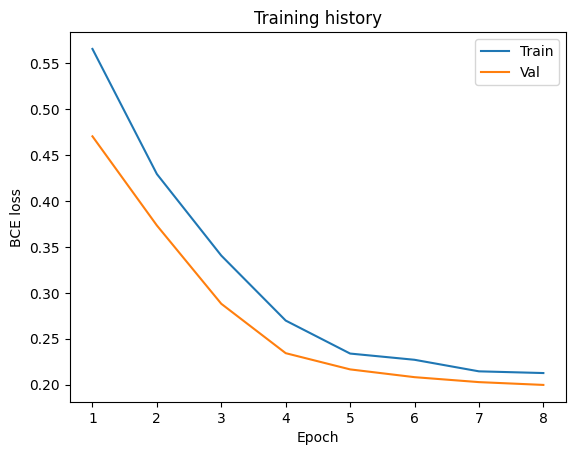

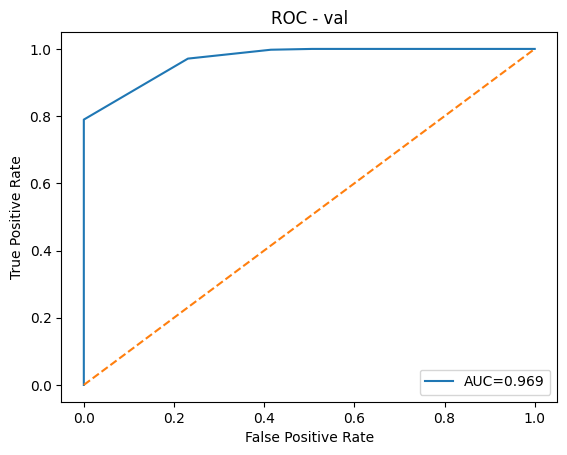

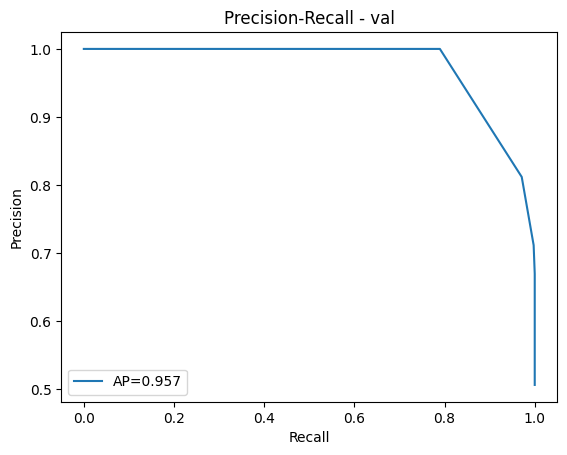

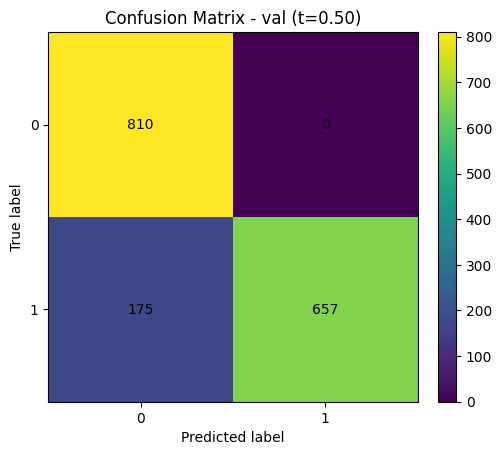

[22:52:26] [predict_loader] N=1642 | logits.shape=(1642,) | y_true.shape=(1642,)
[22:52:26] ✅ Best threshold (F1): 0.18
[22:52:26] 🔎 Validation Accuracy: 0.87
[22:52:26] Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86       810
         1.0       0.81      0.97      0.88       832

    accuracy                           0.87      1642
   macro avg       0.89      0.87      0.87      1642
weighted avg       0.89      0.87      0.87      1642
[22:52:26] AUC-ROC (Validation): 0.97
[22:52:26] Saved: op/tr_va_te_results_20251016_225217/threshold_sweep_val.csv, op/tr_va_te_results_20251016_225217/roc_val.png, op/tr_va_te_results_20251016_225217/pr_val.png, op/tr_va_te_results_20251016_225217/cm_val.png, op/tr_va_te_results_20251016_225217/metrics_val.json, op/tr_va_te_results_20251016_225217/val_report.csv


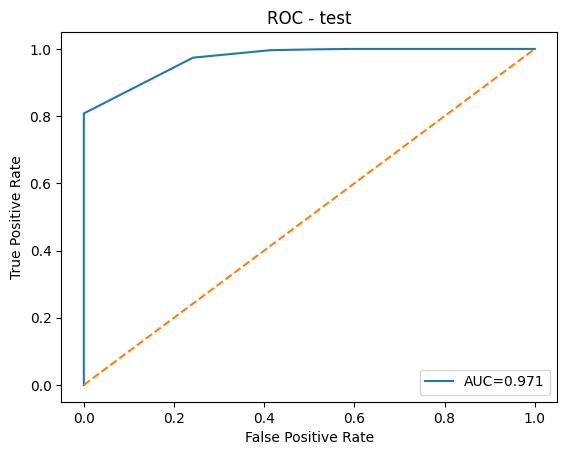

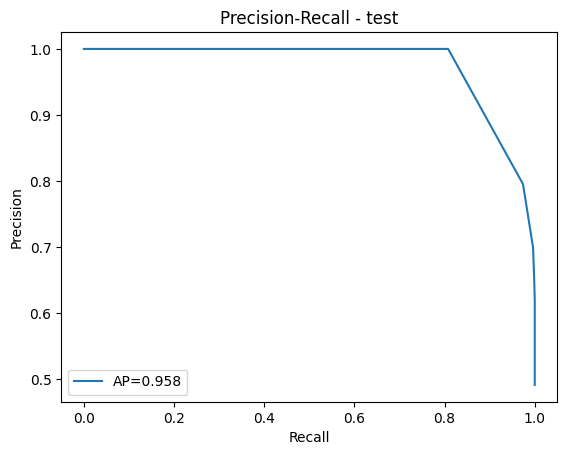

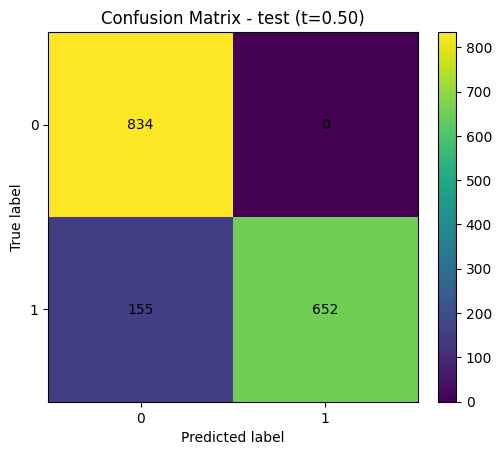

[22:52:27] [predict_loader] N=1641 | logits.shape=(1641,) | y_true.shape=(1641,)
[22:52:27] ✅ Best threshold (F1): 0.38
[22:52:27] 🔎 Test Accuracy: 0.91
[22:52:27] Classification Report:

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91       834
         1.0       1.00      0.81      0.89       807

    accuracy                           0.91      1641
   macro avg       0.92      0.90      0.90      1641
weighted avg       0.92      0.91      0.90      1641
[22:52:27] AUC-ROC (Test): 0.97
[22:52:27] Saved: op/tr_va_te_results_20251016_225217/threshold_sweep_test.csv, op/tr_va_te_results_20251016_225217/roc_test.png, op/tr_va_te_results_20251016_225217/pr_test.png, op/tr_va_te_results_20251016_225217/cm_test.png, op/tr_va_te_results_20251016_225217/metrics_test.json, op/tr_va_te_results_20251016_225217/test_report.csv


"Output dir: {info['out_dir']}"

"SHAP Analysis dir: {info['shap_dir']}"

In [22]:
# Cell 1 — TRAIN / VALIDATE / TEST
# from utils.helpers.tr_va_te_run import run_tr_va_te
# Example: feature_dim = X_tr.shape[2]

model, info = tr_va_te_shap_run.run_tr_va_te(
    X_tr, y_tr, L_tr,
    X_va, y_va, L_va,
    X_te, y_te, L_te,
    feature_dim=X_tr.shape[2],
    config={
        "BATCH_SIZE": 64,
        "EPOCHS": 8,
        "LR": 1e-3,
        "WEIGHT_DECAY": 1e-4,
        "HIDDEN": 128,
        "LAYERS": 1,
        "DROPOUT": 0.2,
        "CLIP_GRAD_NORM": 1.0,
        "EARLY_STOP_PATIENCE": 10,
        "SEED": 42,
    },
    verbose=2,
)

# Artifacts directory for metrics/plots:
display("Output dir: {info['out_dir']}")
# Suggested SHAP output directory to reuse:
display("SHAP Analysis dir: {info['shap_dir']}")


[22:52:27] Run type: validation_data (slug=validation_data)
[22:52:27] SHAP output dir: /home/ppanta/puru_proj/proj_v1/discont_v1/op/shap_analysis_20251016_225217/validation_data
[22:52:27] SHAP setup | background=100 | eval=512 | batch=128
[22:52:27] Creating GradientExplainer...
[22:53:06]   SHAP batch 1/4 | rows 0:128 | 38.43s | 25.0%
[22:53:44]   SHAP batch 2/4 | rows 128:256 | 38.32s | 50.0%
[22:54:22]   SHAP batch 3/4 | rows 256:384 | 38.32s | 75.0%
[22:55:01]   SHAP batch 4/4 | rows 384:512 | 38.94s | 100.0%


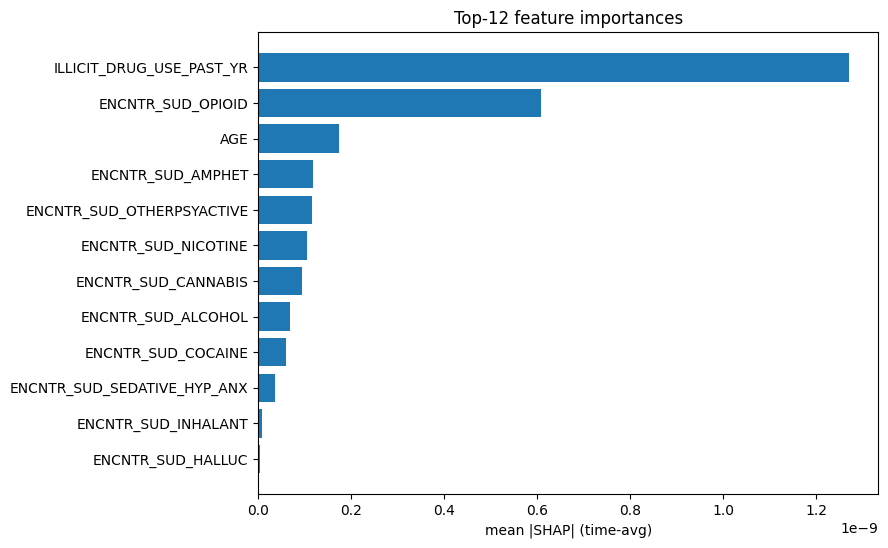

/home/ppanta/puru_proj/proj_v1/discont_v1/utils/tr_va_te_shap_run.py:489: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  _shap.summary_plot(shap_for_plot, features=feat_vals, feature_names=feat_names, show=False, max_display=max_disp)


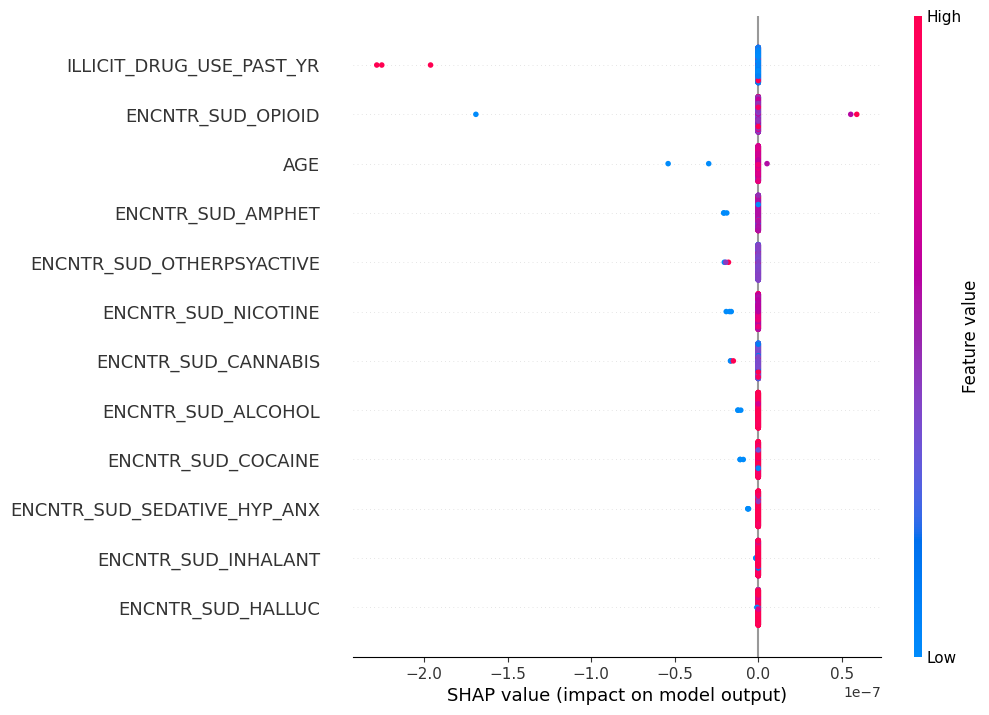

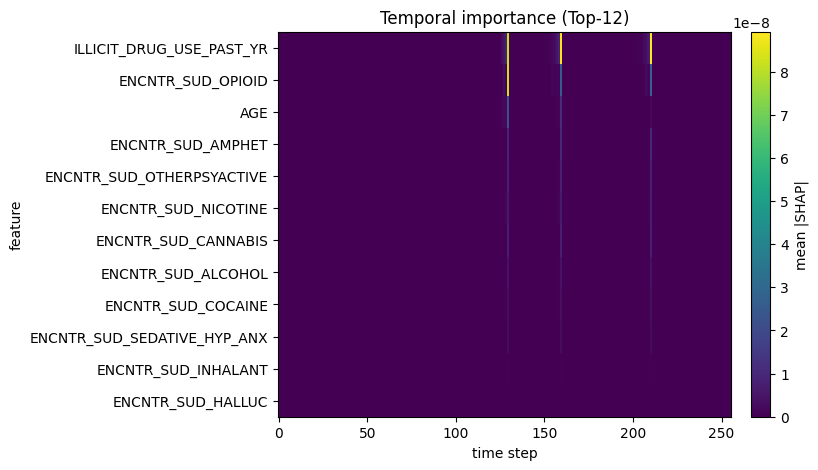

[22:55:03] SHAP analysis complete. Artifacts saved.


{'feature_importance_path': 'op/shap_analysis_20251016_225217/validation_data/validation_data__shap_feature_importance_top12.png',
 'summary_beeswarm_path': 'op/shap_analysis_20251016_225217/validation_data/validation_data__shap_summary_beeswarm.png',
 'dir': 'op/shap_analysis_20251016_225217/validation_data',
 'base_value': 0.5554125308990479,
 'all_importance_csv': 'op/shap_analysis_20251016_225217/validation_data/validation_data__all_importance_shap.csv',
 'run_type': 'validation_data'}

In [23]:
# SHAP Analysis on Validation Data

import torch
# from utils.helpers.shap_analysis import run_shap_analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure your feature_names is a list[str] of length D = X_* shape[2]
assert isinstance(feature_names, list) and len(feature_names) == X_tr.shape[2]

shap_info = tr_va_te_shap_run.run_shap_analysis(
    model=model,           # trained model
    X_bg=X_tr,             # background set (subsampled internally to max_bg)
    X_eval=X_va,           # evaluation set for SHAP (subsampled internally to max_eval)
    L_eval=L_va,           # accepted for signature parity; lengths are recomputed internally
    feature_names=feature_names,
    shap_dir=info["shap_dir"],  # reuse suggested dir from training step
    device=device,
    verbose=2,
    max_bg=100,            # optional knobs
    max_eval=512,
    shap_batch=128,
    topk=30,
    topk_display=20,
    run_type="validation_data", # "validation_data" or "test_data"
)

shap_info


[22:55:03] Run type: test_data (slug=test_data)
[22:55:03] SHAP output dir: /home/ppanta/puru_proj/proj_v1/discont_v1/op/shap_analysis_20251016_225217/test_data
[22:55:03] SHAP setup | background=100 | eval=512 | batch=128
[22:55:03] Creating GradientExplainer...
[22:55:41]   SHAP batch 1/4 | rows 0:128 | 38.26s | 25.0%
[22:56:20]   SHAP batch 2/4 | rows 128:256 | 38.43s | 50.0%
[22:56:58]   SHAP batch 3/4 | rows 256:384 | 38.25s | 75.0%
[22:57:36]   SHAP batch 4/4 | rows 384:512 | 38.24s | 100.0%


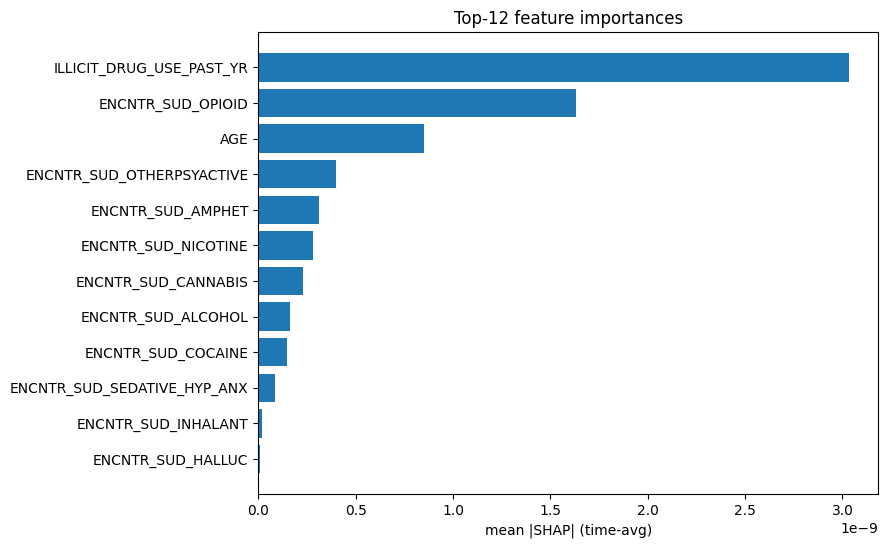

/home/ppanta/puru_proj/proj_v1/discont_v1/utils/tr_va_te_shap_run.py:489: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  _shap.summary_plot(shap_for_plot, features=feat_vals, feature_names=feat_names, show=False, max_display=max_disp)


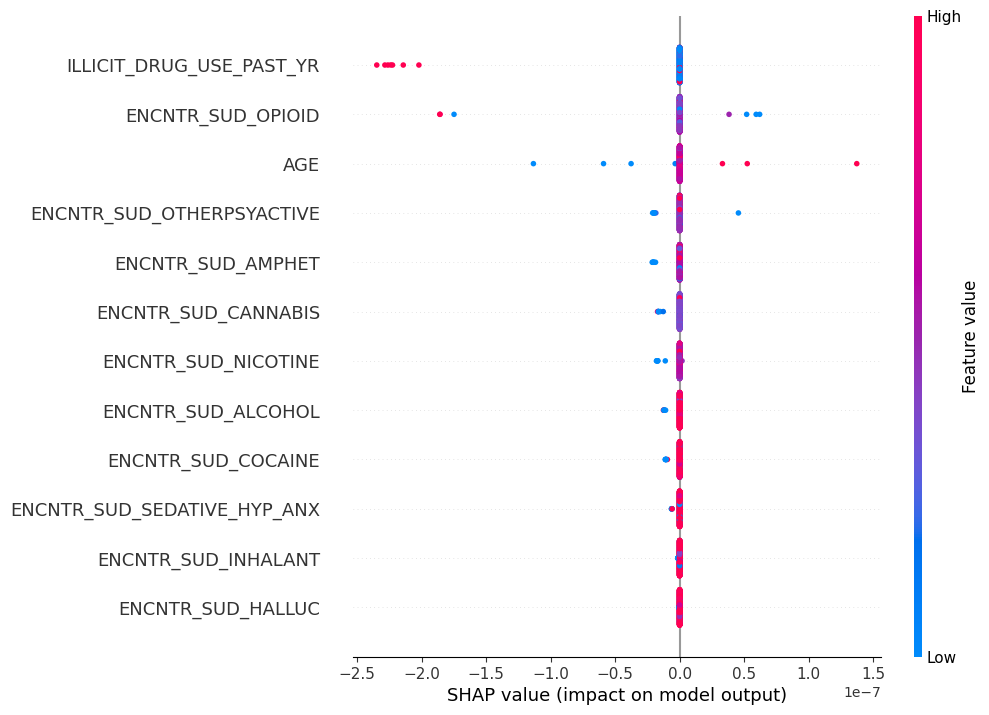

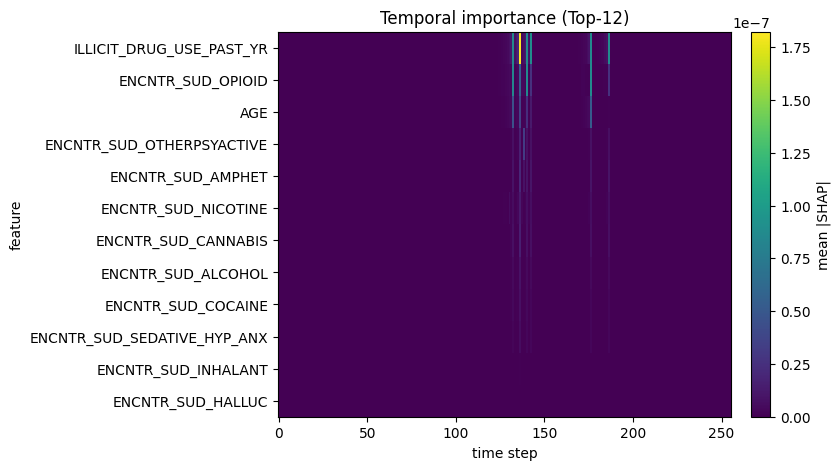

[22:57:38] SHAP analysis complete. Artifacts saved.


{'feature_importance_path': 'op/shap_analysis_20251016_225217/test_data/test_data__shap_feature_importance_top12.png',
 'summary_beeswarm_path': 'op/shap_analysis_20251016_225217/test_data/test_data__shap_summary_beeswarm.png',
 'dir': 'op/shap_analysis_20251016_225217/test_data',
 'base_value': 0.5554125308990479,
 'all_importance_csv': 'op/shap_analysis_20251016_225217/test_data/test_data__all_importance_shap.csv',
 'run_type': 'test_data'}

In [24]:
# SHAP Analysis on Test Data

import torch
# from utils.helpers.shap_analysis import run_shap_analysis
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Ensure your feature_names is a list[str] of length D = X_* shape[2]
assert isinstance(feature_names, list) and len(feature_names) == X_tr.shape[2]

shap_info = tr_va_te_shap_run.run_shap_analysis(
    model=model,           # trained model
    X_bg=X_tr,             # background set (subsampled internally to max_bg)
    X_eval=X_te,           # evaluation set for SHAP (subsampled internally to max_eval)
    L_eval=L_te,           # accepted for signature parity; lengths are recomputed internally
    feature_names=feature_names,
    shap_dir=info["shap_dir"],  # reuse suggested dir from training step
    device=device,
    verbose=2,
    max_bg=100,            # optional knobs
    max_eval=512,
    shap_batch=128,
    topk=30,
    topk_display=20,
    run_type="test_data", # "validation_data" or "test_data"
)

shap_info
